In [1]:

# Requirements: Matplotlib, Numpy, functions_util.py, index.py#, fitting_functions_ZNE.py, h5py

import os

#Move the directory back to Duke_Data
#Check if the current directory is Duke_Data
if os.getcwd().split('/')[-1] != 'DUKE_ANALOG_ZNE_DATA':
    #os.chdir('Duke_Data')
    os.chdir('../')
    #print(os.getcwd().split('/')[-1])
    #pass
else:
    pass
#print(os.getcwd())
from util.index import print_index, get_experiment, index_folder
from util.functions_util import cetina_thermal_exp, cetina_envelope_exp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import numpy as np
import h5py
from util.fitting_functions_ZNE import linear_ZNE, third_no_first_ZNE


def fit(function, x_axis, y_axis, return_cov=False, p0=[.05,2000000], weights=None):
    # Fit the data to the function
    popt, pcov = curve_fit(function, x_axis, y_axis, p0=p0, sigma=weights, absolute_sigma=True, maxfev=10000)
    
    if return_cov:
        return popt, pcov
    return popt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# import all the useful lib in python
from matplotlib import artist as art
%matplotlib inline
import scipy as sp
# import pandas as pd
import pathlib
import os
import datetime as dt
import glob
from IPython.display import clear_output
from numpy.fft import fft, ifft

from util.h5analysis import *
from util.qsim_functions import*


In [3]:

#pairs = [(11,12), (12,13),(13,14)]
#bases = ['x', 'y', 'z']
#pairs_names = [265, 259, 266]
# basis_names = [268, 271, 269]
# foldername = 'Population_4_tw0'
# pairs_names = [str(name) for name in pairs_names]
# qubits = [11,12,13,14]
# shots = 150


#For Bz = 4
# phases = np.array([ 1, 2, 3, 4, 5, 6])*np.pi/6
# phase_names = [572, 573, 574, 575, 576, 577]
# phases_pop = np.array([0])*np.pi/6
# pop_name = [571]
# foldername = '15_chain_4_qubit_B=4'
# shots_pop = 200
#Angle should be 

experiment_list = [ '2 Qubit TFIM', '4 Qubit B4', '4 Qubit B6']
experiment_number = 2
if experiment_number == 0:
    phases = np.array([1, 2, 3, 4, 5, 6])*np.pi/6
    phase_names = [684, 685, 686, 687, 688, 689]
    phases_pop = np.array([0])*np.pi/6
    pop_name = [683]
    shots_pop = 200
    foldername = '27_chain_2_qubit_B2'
    qubits = [15,16]
    all_good_keys=['00','11']
if experiment_number == 1:
    phases = np.array([1, 2, 3, 4, 5, 6])*np.pi/6
    phase_names = [709, 710, 711, 712, 713, 714]
    phases_pop = np.array([0])*np.pi/6
    pop_name = [708]
    shots_pop = 200
    qubits = [13,14,15,16]
    foldername = '27_chain_4_qubit_B4'
    all_good_keys=['0000','1111']
if experiment_number == 2:
    phases = np.array([1, 2, 3, 4, 5, 6])*np.pi/6
    phase_names = [716, 717, 718, 719, 720, 721]
    phases_pop = np.array([0])*np.pi/6
    pop_name = [715]
    shots_pop = 200
    qubits = [13,14,15,16]
    foldername = '27_chain_4_qubit_B6'
    all_good_keys=['0000','1111']




#shots = 600
shots = 200
time_steps = 21



# for name_index in range(len(pairs_names)):
#     name = pairs_names[name_index]
#     if '000563' in pairs_names:
#         pass
#     else:
#         name = '000563' + name
#         pairs_names[name_index] = name
phase_names = [str(name) for name in phase_names]
for name_index in range(len(phase_names)):
    name = phase_names[name_index]
    if '000572' in phase_names:
        pass
    else:
        name = '000572' + name
        phase_names[name_index] = name
        
pop_name = [str(name) for name in pop_name]
for name_index in range(len(pop_name)):
    name = pop_name[name_index]
    if '000572' in pop_name:
        pass
    else:
        name = '000572' + name
        pop_name[name_index] = name
full_data_folder_path = './data/' + foldername + '/'


In [4]:
COUNTS_THRESHOLD = 1


In [5]:
measurement_data = np.zeros((time_steps, len(phase_names)), dtype=dict)
#flopping_matrix = np.zeros((30, len(pairs_names)))
#flopping_std_matrix = np.zeros((30, len(pairs_names)))
#times = None

expectations_matrix = np.zeros((time_steps,len(phase_names)))
qubit_0_magnetization = np.zeros((time_steps,len(phase_names)))
leakage_factor = np.zeros((time_steps,len(phase_names)))

print(os.getcwd())
for file_id_index in range(len(phase_names)):
    
    file_id = phase_names[file_id_index]
    phase = phases[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    if file_id_index == 0:
        times_start = times
    if file_id_index == 3:
        times_end = times
    #print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts[:,0])
    #print()
    #print(counts.shape)
    measurements = np.zeros((len(qubits), shots, time_steps))
    for qubit_index in range(len(qubits)):
        qubit = qubits[qubit_index]
        #qubit = pair[pair_index]
        measurements[qubit_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots, time_steps), dtype='<U5')
    for i in range(shots):
        for j in range(time_steps):
            bitstring = [str(int(measurements[qubit_index,i,j])) for qubit_index in range(len(qubits))]
            bitstring = "".join(bitstring)
            counts_bitstrings[i,j] = bitstring
    counts_dicts = np.zeros(time_steps, dtype=dict)
    for j in range(time_steps):
        magnetization = 0
        for shot_index in range(shots):
            magnetization += measurements[0, shot_index, j]*2 - 1
        qubit_0_magnetization[j,file_id_index] = magnetization/shots
        temp_dict = {}#
        #{'0000':0, '1111':0}
        for i in range(shots):
            if counts_bitstrings[i,j] in temp_dict:
                temp_dict[counts_bitstrings[i,j]] += 1/shots
            else:
                temp_dict[counts_bitstrings[i,j]] = 1/shots
        counts_dicts[j] = temp_dict
        expectation = 0
        for key in temp_dict.keys():
            #count the number of zeros. If it is even, add the value. If it is odd, subtract the value
            num_zeros = key.count('0')
            if num_zeros % 2 == 0:
                expectation += temp_dict[key]
            else:
                expectation -= temp_dict[key]
        expectations_matrix[j,file_id_index] = expectation
        print(expectation)
    measurement_data[:,file_id_index] = counts_dicts
    
    

    
#print(counts_array)

/Users/thomassteckmann/Duke_Analog_ZNE_data
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [6]:
# #Good keys are keys which are hamming distance 1 away from 0000 or 1111
# all_good_keys = ['0000', '1111', '0001', '0010', '0100', '1000', '1110', '1101', '1011', '0111']
# all_good_keys=['00','11']

In [7]:
measurement_data_pop = np.zeros((time_steps, len(pop_name)), dtype=dict)
#flopping_matrix = np.zeros((30, len(pairs_names)))
#flopping_std_matrix = np.zeros((30, len(pairs_names)))
#times = None

expectations_matrix_pop = np.zeros((time_steps,len(pop_name)))
expectation_ZZZZ_pop = np.zeros((time_steps,len(pop_name)))
qubit_0_magnetization_pop = np.zeros((time_steps,len(pop_name)))
leakage_factor_pop = np.zeros((time_steps,len(pop_name)))

print(os.getcwd())
for file_id_index in range(len(pop_name)):
    
    file_id = pop_name[file_id_index]
    phase = phases_pop[file_id_index]
    #pair = names[0]
    file = h5py.File(full_data_folder_path + file_id + '-RFSoCSequence.h5', 'r')
    archive = file['archive']
    dataset = file['datasets']
    x_vals = dataset['data.rfsoc_pulse_sequence.x_values']
    times = np.array(x_vals)
    if file_id_index == 0:
        times_start = times
    if file_id_index == 3:
        times_end = times
    #print(times)
    raw_counts = dataset['data.rfsoc_pulse_sequence.raw_counts']
    counts = np.asarray(raw_counts)
    print(counts.shape)
    measurements = np.zeros((len(qubits), shots_pop, time_steps))
    for qubit_index in range(len(qubits)):
        qubit = qubits[qubit_index]
        #qubit = pair[pair_index]
        measurements[qubit_index,:,:] = 1 < counts[qubit,:,:]
        #print(measurements)
    #Convert the measurements to bitstrings. Convert to string, then append the like indices
    counts_bitstrings = np.zeros((shots_pop, time_steps), dtype='<U5')
    for i in range(shots_pop):
        for j in range(time_steps):
            bitstring = [str(int(measurements[qubit_index,i,j])) for qubit_index in range(len(qubits))]
            bitstring = "".join(bitstring)
            counts_bitstrings[i,j] = bitstring
    counts_dicts = np.zeros(time_steps, dtype=dict)
    for j in range(time_steps):
        magnetization = 0
        for shot_index in range(shots_pop):
            magnetization += measurements[0, shot_index, j]*2 - 1
        qubit_0_magnetization_pop[j,file_id_index] = magnetization/shots_pop
        temp_dict = {}#
        #{'0000':0, '1111':0}
        for i in range(shots_pop):
            if counts_bitstrings[i,j] in temp_dict:
                temp_dict[counts_bitstrings[i,j]] += 1/shots_pop
            else:
                temp_dict[counts_bitstrings[i,j]] = 1/shots_pop
        counts_dicts[j] = temp_dict
        expectation = 0
        expectation_ZZZZ = 0
        print('---')
        for key in temp_dict.keys():
            print(key, temp_dict[key])
            if key in all_good_keys:
                expectation += temp_dict[key]
                
            count_zero = key.count('0')
            if count_zero % 2 == 0:
                expectation_ZZZZ += temp_dict[key]
            else:
                expectation_ZZZZ -= temp_dict[key]
        expectation_ZZZZ_pop[j,file_id_index] = expectation_ZZZZ

        expectations_matrix_pop[j,file_id_index] = expectation
        #print(expectation)
    measurement_data_pop[:,file_id_index] = counts_dicts
    
    

    
#print(counts_array)

/Users/thomassteckmann/Duke_Analog_ZNE_data
(23, 200, 21)
---
1011 0.025
1111 0.18500000000000008
0000 0.16500000000000006
1010 0.02
0010 0.049999999999999996
1000 0.05999999999999999
1100 0.05999999999999999
0011 0.04
1110 0.05999999999999999
0101 0.05999999999999999
0001 0.06499999999999999
1101 0.035
0110 0.02
0111 0.09500000000000001
0100 0.049999999999999996
1001 0.01
---
0111 0.085
0000 0.16500000000000006
1111 0.17000000000000007
0100 0.049999999999999996
0110 0.049999999999999996
1100 0.049999999999999996
1110 0.075
0001 0.04
1000 0.049999999999999996
0010 0.045
0101 0.04
1101 0.045
0011 0.045
1001 0.04
1010 0.025
1011 0.025
---
1111 0.2000000000000001
0100 0.06499999999999999
1110 0.05999999999999999
0000 0.14000000000000004
0011 0.05999999999999999
0010 0.06499999999999999
1000 0.045
1100 0.035
1011 0.06499999999999999
1010 0.05499999999999999
0101 0.04
0110 0.045
1101 0.035
0001 0.049999999999999996
0111 0.035
1001 0.005
---
0010 0.075
1100 0.08
0000 0.18500000000000008
0011

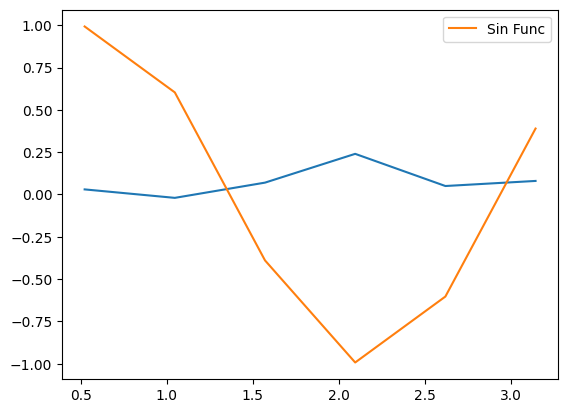

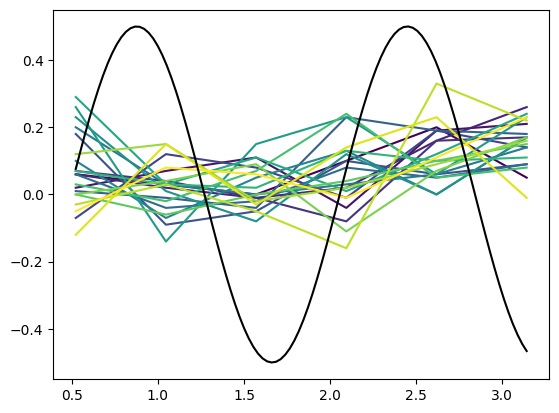

In [8]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4), label='Sin Func')
plt.legend()
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(time_steps):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
phases_dense = np.linspace(np.pi/6, np.pi, 100)
ax.plot(phases_dense, -0.5*np.sin(len(qubits)*np.array(phases_dense)+1.2 ), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)



[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[-0. -2. -4.  6.  4.  2.]
[0.05238745 0.10477489 0.04932883 0.06437736 0.11789826 0.09386752
 0.02905933 0.03756476 0.04096069 0.0983757  0.10263203 0.17457886
 0.06009252 0.02333333 0.06928203 0.03666667 0.10744508 0.03333333
 0.16127961 0.13114877 0.1040833 ]
11
3.4557519189487724
0.17457885819338842


/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


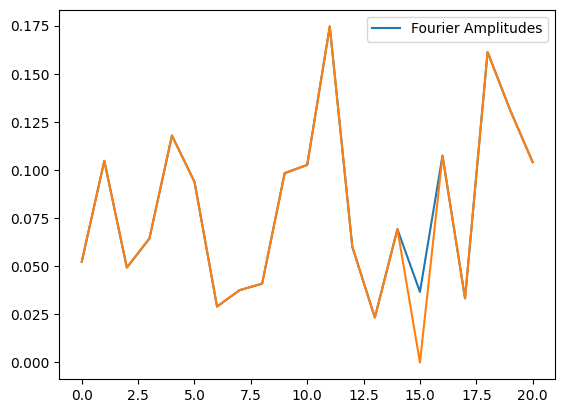

In [9]:
amps = np.zeros(time_steps)
for i in range(time_steps):
    test = data_matrix[i,:]
    fft_test = np.fft.fft(test)*2/len(test)
    frequencies = np.fft.fftfreq(len(test), phases[0]-phases[1])*2*np.pi
    print(frequencies)
    #index of len(qubits) in the frequencies array:
    good_index = np.argmin(np.abs(frequencies - len(qubits)))
    #print(frequencies)
    amp_4 = np.abs(fft_test[good_index])
    amps[i] = amp_4
amps_fit = np.zeros(time_steps)
def sin_fit(x, a, b,c):
    return np.sin(len(qubits)*x + c)*a + b

for i in range(time_steps):
    test = data_matrix[i,:]
    popt, pcov = curve_fit(sin_fit, phases, test, p0=[0.5,0,0])
    amps_fit[i] = abs(popt[0])
    
    
plt.plot(range(time_steps), amps, label='Fourier Amplitudes')
plt.plot(range(time_steps), amps_fit)
plt.legend()
#return the index of the maximum amplitude
max_index = np.argmax(amps[:-5])
print(amps)
print(max_index)
Z_rotations = np.linspace(0, 2*np.pi, time_steps, endpoint=True)
print(Z_rotations[max_index])
print(amps_fit[max_index])


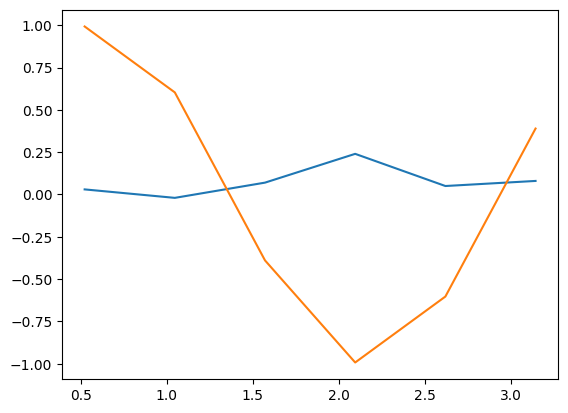

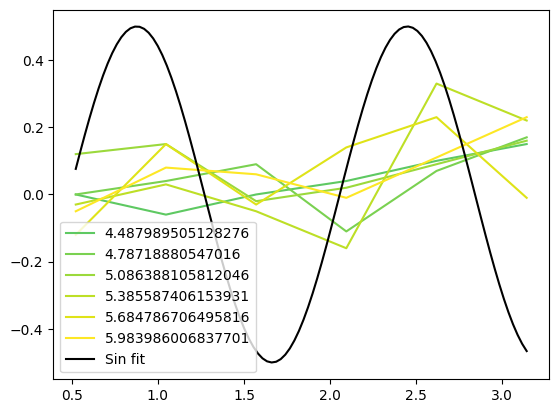

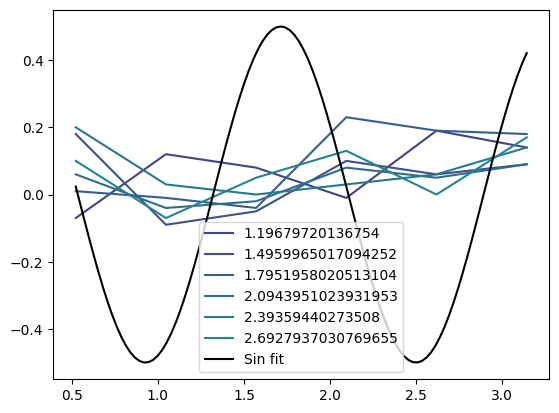

In [10]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4))
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(15,time_steps):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
phases_dense = np.linspace(np.pi/6, np.pi, 100)
ax.plot(phases_dense, -0.5*np.sin(4*np.array(phases_dense)+1.2 ), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()
plt.show()

fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(4,10):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
phases_dense = np.linspace(np.pi/6, np.pi, 100)
ax.plot(phases_dense, 0.5*np.sin(4*np.array(phases_dense)+1 ), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()
plt.show()

In [11]:
expectations_matrix_pop

array([[0.35 ],
       [0.335],
       [0.34 ],
       [0.415],
       [0.345],
       [0.325],
       [0.36 ],
       [0.385],
       [0.36 ],
       [0.305],
       [0.365],
       [0.33 ],
       [0.325],
       [0.31 ],
       [0.295],
       [0.28 ],
       [0.39 ],
       [0.365],
       [0.36 ],
       [0.325],
       [0.355]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3
0.9424777960769379
0.4150000000000002


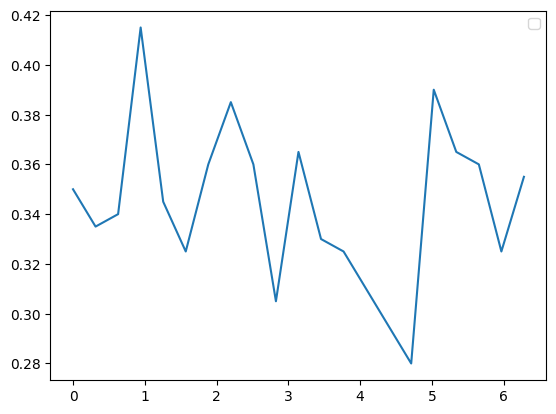

In [12]:

#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()

ax.plot(np.linspace(0, 2*np.pi, time_steps), expectations_matrix_pop[:,0])

#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()
#Get the index of the peak:
peak_index = np.argmax(expectations_matrix_pop[:,0])
print(peak_index)
print(Z_rotations[peak_index])
print(expectations_matrix_pop[peak_index,0])

IndexError: index 30 is out of bounds for axis 0 with size 21

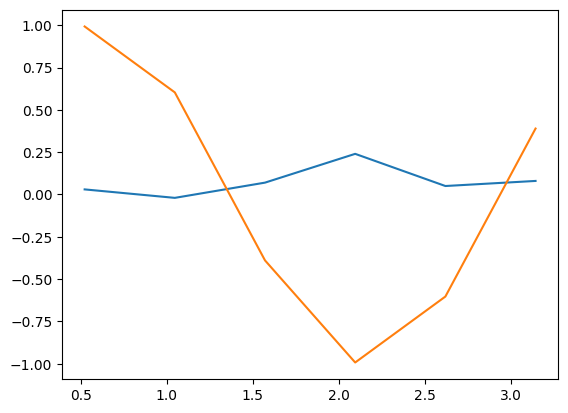

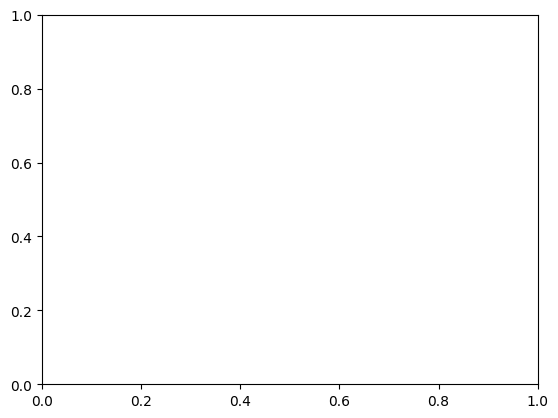

In [13]:
data_matrix = np.zeros((time_steps, len(phase_names)))
for i in range(len(phase_names)):
    data_matrix[:,i] = expectations_matrix[:,i]
plt.plot(phases, data_matrix[14,:])
plt.plot(phases, np.sin(2*np.array(phases)+0.4))
#Plot each index int he time step using a different color from a color bar
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0, 1, time_steps))
for i in range(30,34):
    ax.plot(phases, data_matrix[i,:], color=colors[i], label=i/time_steps*2*np.pi)
ax.plot(phases, 0.8*np.sin(2*np.array(phases)+0.6), color='black', label='Sin fit')
#cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax)
plt.legend()

In [ ]:
x_axis = [val for val in x_vals]

ValueError: x and y must be the same size

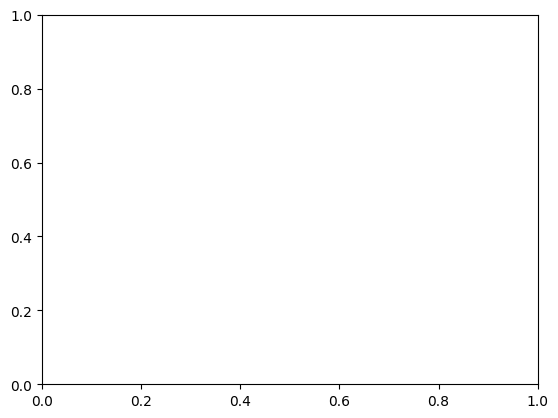

In [ ]:
plt.scatter(phases, expectations_matrix[:,0])
#Fit each of the axies to a sign function:

plt.plot(x_axis, .8*np.cos(np.array(x_axis)*2))

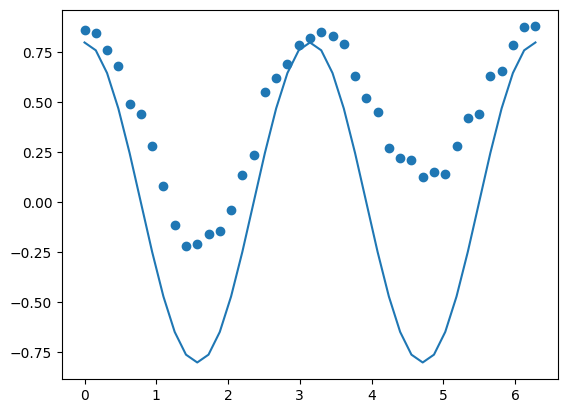

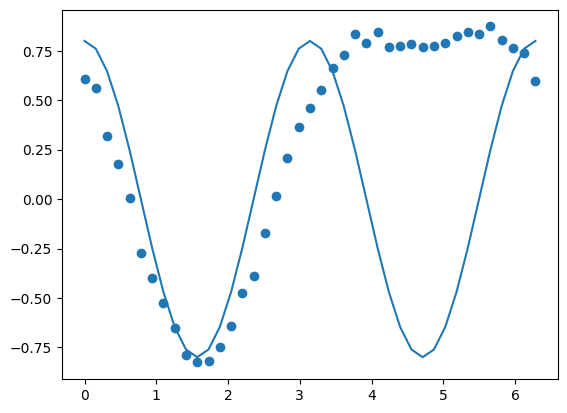

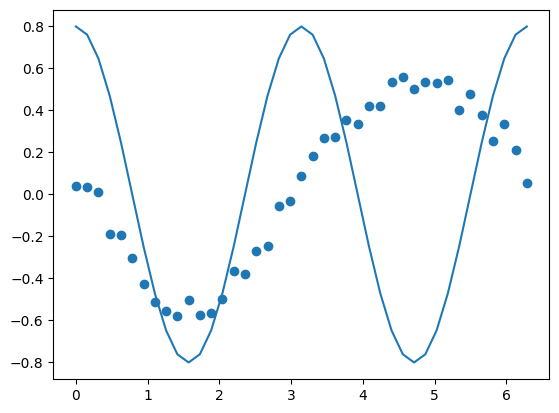

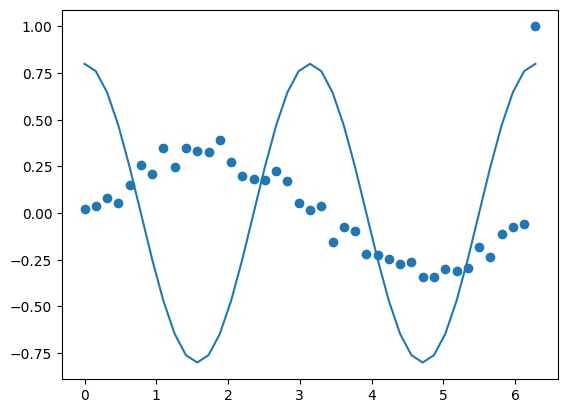

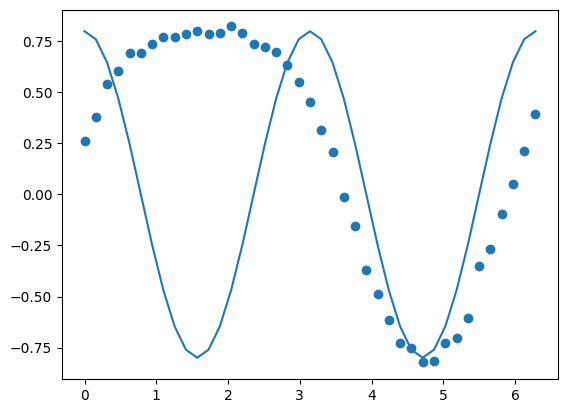

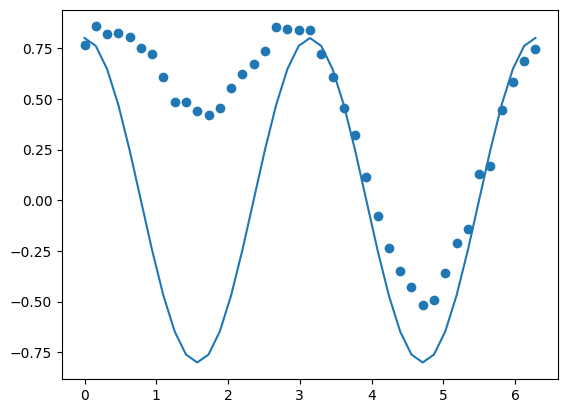

In [ ]:
for i in range(6):
    

    plt.scatter(x_axis, expectations_matrix[:,i])
    #Fit each of the axies to a sign function:

    plt.plot(x_axis, .8*np.cos(np.array(x_axis)*2))
    plt.show()

In [ ]:
print(expectations_matrix)

[[ 0.83]
 [ 0.82]
 [ 0.58]
 [ 0.49]
 [ 0.01]
 [ 0.14]
 [-0.12]
 [-0.15]
 [-0.57]
 [-0.57]
 [-0.53]
 [-0.56]
 [-0.43]
 [-0.34]
 [-0.08]
 [ 0.08]
 [ 0.23]
 [ 0.41]
 [ 0.47]
 [ 0.65]
 [ 0.82]
 [ 0.8 ]
 [ 0.92]
 [ 0.9 ]
 [ 0.8 ]
 [ 0.82]
 [ 0.62]
 [ 0.6 ]
 [ 0.6 ]
 [ 0.53]
 [ 0.48]
 [ 0.6 ]
 [ 0.56]
 [ 0.65]
 [ 0.57]
 [ 0.78]
 [ 0.87]
 [ 0.9 ]
 [ 0.85]
 [ 0.77]
 [ 0.8 ]]


TypeError: Improper input: func input vector length N=4 must not exceed func output vector length M=1

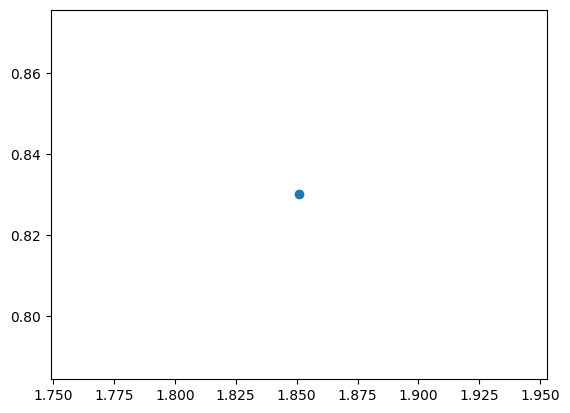

In [ ]:
plt.scatter(phases, expectations_matrix[0,:])
#Fit to a sin function:
def sine(x, A, B, C, D):
    return A*np.sin(B*x + C) + D
phases_sorted = phases.copy()
phases_dense = np.linspace(0, 1.25*np.pi, 1000)
phases_sorted.sort()
popt, pcov = fit(sine, phases, expectations_matrix[0,:], return_cov=True, p0=[.5, 2, 0, 0])
plt.plot(phases_dense, sine(phases_dense, *popt))
print(popt[0])
